In [11]:
import re
import string
from transformers import pipeline
import nltk
import pandas as pd
from datasets import load_dataset
from transformers import T5Tokenizer, T5ForConditionalGeneration, Trainer, TrainingArguments
# from sklearn.model_selection import train_test_split
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/paramatephuengtrakul/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/paramatephuengtrakul/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/paramatephuengtrakul/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# 1. Load the QMSum dataset from Hugging Face
dataset = load_dataset("pszemraj/qmsum-cleaned")

In [3]:
# 2. Load the T5 tokenizer and model (using t5-base in this example)
tokenizer = T5Tokenizer.from_pretrained("t5-base", legacy=False)
model = T5ForConditionalGeneration.from_pretrained("t5-base")

In [4]:
# 3. Preprocessing: tokenize inputs (meeting transcripts) and targets (summaries)
def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove HTML tags (if any)
    text = re.sub(r'<.*?>', '', text)
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove extra whitespace
    text = ' '.join(text.split())
    return text

# Map a preprocessing function over the dataset to add new columns for cleaned transcript and summary
def preprocess_record(record):
    record["clean_input"] = clean_text(record["input"])
    record["clean_output"] = clean_text(record["output"])
    return record


def preprocess_function(examples):
    # Assuming the dataset contains "transcript" and "summary" fields.
    inputs = examples["input"]
    targets = examples["output"]
    
    # Tokenize the input transcript (adjust max_length as needed)
    model_inputs = tokenizer(inputs, max_length=1024, truncation=True)
    
    # Tokenize the target summary
    labels = tokenizer(targets, max_length=256, truncation=True)
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [5]:
print("Available splits:", list(dataset.keys()))
print("Columns in the train split:", dataset["train"].column_names)
print("Features of the train split:")
print(dataset["train"].features)

Available splits: ['train', 'validation', 'test']
Columns in the train split: ['id', 'pid', 'input', 'output', 'input_token_count', 'output_token_count']
Features of the train split:
{'id': Value(dtype='string', id=None), 'pid': Value(dtype='string', id=None), 'input': Value(dtype='string', id=None), 'output': Value(dtype='string', id=None), 'input_token_count': Value(dtype='int64', id=None), 'output_token_count': Value(dtype='int64', id=None)}


In [ ]:
# Inspect the first example in the training split
first_example = dataset["train"][0]
print("\nFirst example in 'train':")
print(first_example)

In [7]:
# If you want to inspect just the text data (assuming 'transcript' is the key)
print("\nNumber of input token of the first example")
print(first_example.get('input_token_count', "Key 'transcript' not found."))


Number of input token of the first example
8221


In [7]:
# Select the 'train' split (this returns a Dataset object)
train_dataset = dataset["train"]

# Convert the train split to a pandas DataFrame
df = train_dataset.to_pandas()

In [8]:
# Number of unique meetings (using the "pid" column)
num_unique_meetings = df["pid"].nunique()
print("Number of unique meetings:", num_unique_meetings)

Number of unique meetings: 1257


In [9]:
# Input token count statistics
max_input_tokens = df["input_token_count"].max()
min_input_tokens = df["input_token_count"].min()
avg_input_tokens = df["input_token_count"].mean()
print("\nInput token counts -- Max: {}, Min: {}, Average: {:.2f}".format(
    max_input_tokens, min_input_tokens, avg_input_tokens))


Input token counts -- Max: 40347, Min: 1746, Average: 14953.12


In [15]:
# Output token count statistics
max_output_tokens = df["output_token_count"].max()
min_output_tokens = df["output_token_count"].min()
avg_output_tokens = df["output_token_count"].mean()
print("Output token counts -- Max: {}, Min: {}, Average: {:.2f}".format(
    max_output_tokens, min_output_tokens, avg_output_tokens))


Output token counts -- Max: 311, Min: 19, Average: 88.34


In [18]:
df

,id,pid,input,output,input_token_count,output_token_count
0,tr-sq-1,tr-sq-1_0,How Did Project Manager and User Interface int...,Project Manager introduced that the prototype ...,8221,111
1,tr-sq-2,tr-sq-2_0,How did Marketing design the product evaluatio...,Marketing had some evaluation criteria in mind...,8214,76
2,tr-sq-3,tr-sq-3_0,What did the team discuss during the product e...,"Generally speaking, the team agreed that the p...",8227,101
3,tr-sq-4,tr-sq-4_0,How did the team evaluate the product about it...,"To start with, the team agreed that the remote...",8220,86
4,tr-sq-5,tr-sq-5_0,What did the team discuss about the product co...,Project Manager first introduced the budget an...,8216,121
...,...,...,...,...,...,...
1252,tr-sq-1253,tr-sq-1253_0,What did Bill Blair respond to the firearms se...,"According to Bill Blair, gun violence in any o...",28240,92
1253,tr-sq-1254,tr-sq-1254_0,Summarize the inquiries towards Service Canada...,"As John Williamson, the member from New Brunsw...",28228,126
1254,tr-sq-1255,tr-sq-1255_0,Why did John Williamson disagree with the gove...,Since there was a lot of absence in public ser...,28232,103
1255,tr-sq-1256,tr-sq-1256_0,What did Bergeron think of the cooperation bet...,When it comes to the cooperation between two l...,28241,108


In [30]:
dataset = dataset.map(preprocess_record)

In [33]:
# Convert to Pandas DataFrame and save to CSV
dataset_train = dataset['train']
dataset_val = dataset['validation']
dataset_test = dataset['test']


cleaned_train = dataset_train.to_pandas()
cleaned_train.to_csv("cleaned_qmsum_train.csv", index=False)
print("Cleaned data saved to 'cleaned_qmsum_train.csv'")

cleaned_val = dataset_val.to_pandas()
cleaned_val.to_csv("cleaned_qmsum_val.csv", index=False)
print("Cleaned data saved to 'cleaned_qmsum_val.csv'")

dataset_test = dataset_test.to_pandas()
dataset_test.to_csv("cleaned_qmsum_test.csv", index=False)
print("Cleaned data saved to 'cleaned_qmsum_test.csv'")

Cleaned data saved to 'cleaned_qmsum_train.csv'
Cleaned data saved to 'cleaned_qmsum_val.csv'
Cleaned data saved to 'cleaned_qmsum_test.csv'


In [34]:
import pandas as pd
df_test = pd.read_csv("cleaned_qmsum_test.csv")
df_test.head()

,id,pid,input,output,input_token_count,output_token_count,clean_input,clean_output
0,te-sq-1,te-sq-1_0,Summarize the discussion about the efficacy of...,NaN,14287,0,summarize the discussion about the efficacy of...,NaN
1,te-sq-2,te-sq-2_0,What did Barry Hughes think about the legal fr...,NaN,14293,0,what did barry hughes think about the legal fr...,NaN
2,te-sq-3,te-sq-3_0,What was the two-stage test during prosecution...,NaN,14293,0,what was the twostage test during prosecutions...,NaN
3,te-sq-4,te-sq-4_0,Summarize the discussion about the divergence ...,NaN,14291,0,summarize the discussion about the divergence ...,NaN
4,te-sq-5,te-sq-5_0,What did Barry Hughes think about the implicat...,NaN,14303,0,what did barry hughes think about the implicat...,NaN


In [12]:
dataset = dataset.map(preprocess_record)
# Convert to Pandas DataFrame and save to CSV
dataset_train = dataset['train']
dataset_val = dataset['validation']

Map: 100%|██████████| 281/281 [00:00<00:00, 379.75 examples/s]


NameError: name 'cleaned_train' is not defined

In [14]:
cleaned_train = dataset_train.to_pandas()
cleaned_val = dataset_val.to_pandas()
combined_df = pd.concat([cleaned_train, cleaned_val], ignore_index=True)

In [15]:
combined_df.shape

(1529, 8)

In [17]:
!pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 5.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.3/253.3 kB 5.0 MB/s eta 0:00:00a 0:00:01
  Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 6.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.4/65.4 kB 6.2 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


Matplotlib is building the font cache; this may take a moment.


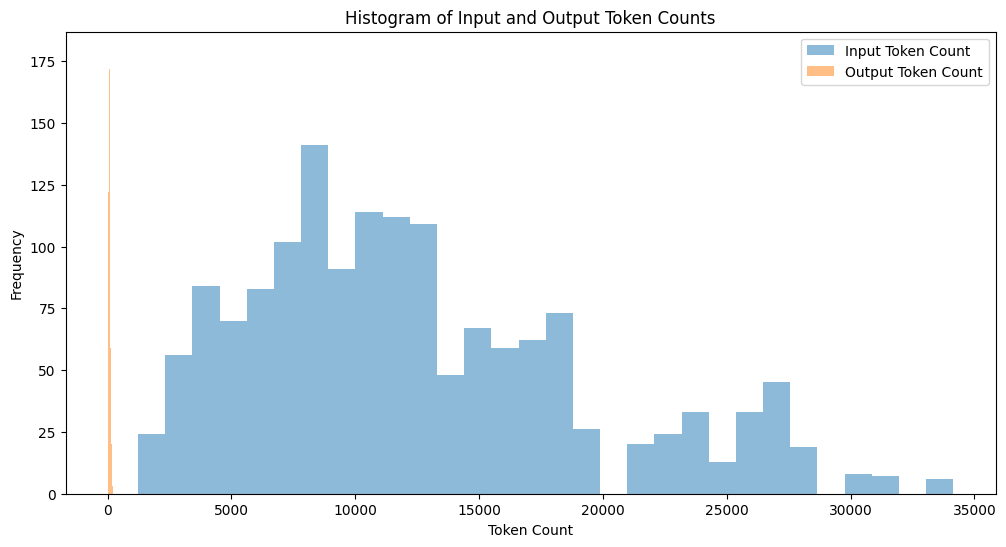

In [18]:
import matplotlib.pyplot as plt
# If you applied the cleaning function earlier, the dataset may have "clean_input" and "clean_output" columns.
# Adjust the following column names accordingly.
input_column = "clean_input" if "clean_input" in combined_df.columns else "input"
output_column = "clean_output" if "clean_output" in combined_df.columns else "output"

# Count tokens for each row using the T5 tokenizer
combined_df["input_token_count"] = combined_df[input_column].apply(lambda x: len(tokenizer.tokenize(x)))
combined_df["output_token_count"] = combined_df[output_column].apply(lambda x: len(tokenizer.tokenize(x)))

# Plot histograms for input and output token counts
plt.figure(figsize=(12, 6))
plt.hist(combined_df["input_token_count"], bins=30, alpha=0.5, label='Input Token Count')
plt.hist(combined_df["output_token_count"], bins=30, alpha=0.5, label='Output Token Count')
plt.xlabel("Token Count")
plt.ylabel("Frequency")
plt.title("Histogram of Input and Output Token Counts")
plt.legend(loc='upper right')
plt.show()

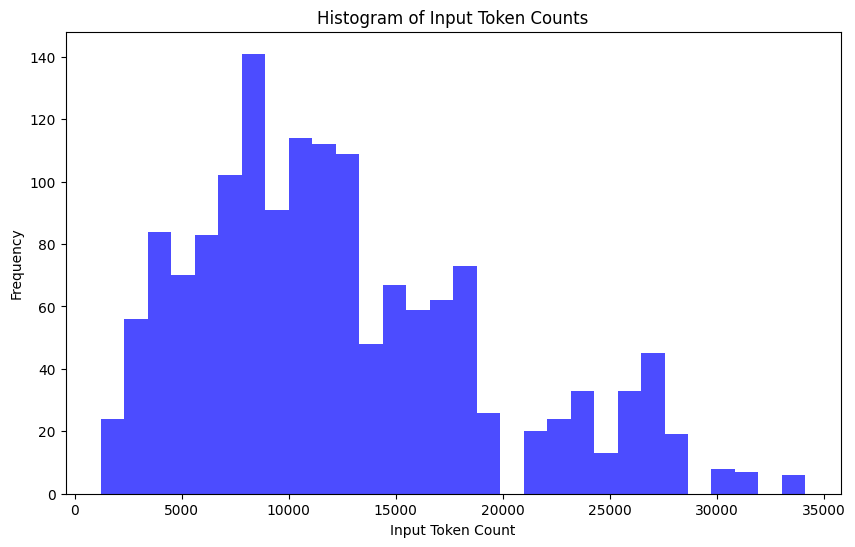

In [19]:
# Plot histogram for input token counts
plt.figure(figsize=(10, 6))
plt.hist(combined_df["input_token_count"], bins=30, color='blue', alpha=0.7)
plt.xlabel("Input Token Count")
plt.ylabel("Frequency")
plt.title("Histogram of Input Token Counts")
plt.show()


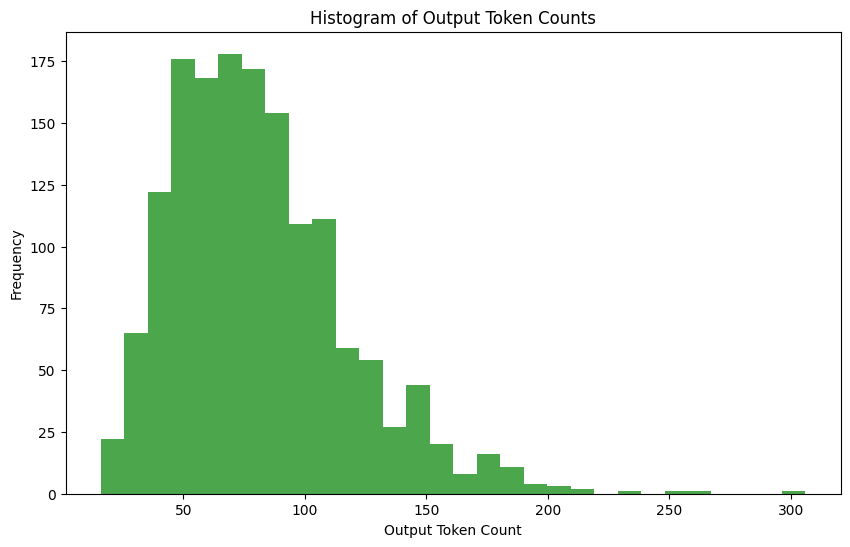

In [20]:
# Plot histogram for output token counts
plt.figure(figsize=(10, 6))
plt.hist(combined_df["output_token_count"], bins=30, color='green', alpha=0.7)
plt.xlabel("Output Token Count")
plt.ylabel("Frequency")
plt.title("Histogram of Output Token Counts")
plt.show()

In [27]:
# Compute mean and standard deviation for input token counts
input_mean = combined_df["input_token_count"].mean()
input_std = combined_df["input_token_count"].std()
# Compute mean and standard deviation for output token counts
output_mean = combined_df["output_token_count"].mean()
output_std = combined_df["output_token_count"].std()

print("Input Token Count - Mean: {:.2f}, Standard Deviation: {:.2f}".format(input_mean, input_std))
print("Output Token Count - Mean: {:.2f}, Standard Deviation: {:.2f}".format(output_mean, output_std))

Input Token Count - Mean: 12413.49, Standard Deviation: 6878.99
Output Token Count - Mean: 81.21, Standard Deviation: 36.15


In [21]:
# Shuffle the combined dataset using Pandas sample
combined_df = combined_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Determine the index for 80% of the data
split_index = int(0.8 * len(combined_df))

# Split the data into train and validation DataFrames
train_df = combined_df.iloc[:split_index].copy()
val_df = combined_df.iloc[split_index:].copy()

In [49]:
# Shuffle the combined dataset using Pandas sample
# combined_df = combined_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Separate the test set (100 rows)
test_df = combined_df.iloc[:100].copy()
remaining_df = combined_df.iloc[100:].copy()

# Split the remaining data into train and validation (80:20)
split_index = int(0.8 * len(remaining_df))
train_df = remaining_df.iloc[:split_index].copy()
val_df = remaining_df.iloc[split_index:].copy()

# Optional: Print out the sizes of each dataset
print("Test dataset size:", len(test_df))
print("Train dataset size:", len(train_df))
print("Validation dataset size:", len(val_df))

Test dataset size: 100
Train dataset size: 1143
Validation dataset size: 286


In [50]:
train_df.to_csv("train_set_qsum.csv", index=False)
val_df.to_csv("val_set_qsum.csv", index=False)
test_df.to_csv("test_set_qsum.csv", index=False)

In [39]:
train_df.shape, val_df.shape

((1223, 8), (306, 8))

In [40]:
train_df.head()

,id,pid,input,output,input_token_count,output_token_count,clean_input,clean_output
0,tr-sq-440,tr-sq-440_0,What did User Interface introduce about the de...,User Interface suggested that the prototype of...,6272,112,what did user interface introduce about the de...,user interface suggested that the prototype of...
1,tr-sq-77,tr-sq-77_0,What did Janet Finch-Saunders think of childca...,The Welsh and UK Governments had followed a de...,15363,112,what did janet finchsaunders think of childcar...,the welsh and uk governments had followed a de...
2,va-sq-14,va-sq-14_0,What did the group discuss about the functions...,The User Interface proposed to build a stand-a...,6764,59,what did the group discuss about the functions...,the user interface proposed to build a standal...
3,tr-sq-662,tr-sq-662_0,What statistics were included in the paper?\nG...,The statistics in the paper are based on the t...,24205,48,what statistics were included in the paper gra...,the statistics in the paper are based on the t...
4,tr-sq-1037,tr-sq-1037_0,What did the team discuss about politics aroun...,The team knew that the CMU folks had collected...,28573,52,what did the team discuss about politics aroun...,the team knew that the cmu folks had collected...


In [41]:
val_df.head()

,id,pid,input,output,input_token_count,output_token_count,clean_input,clean_output
1223,tr-sq-1073,tr-sq-1073_0,What did group mates think of a universal desi...,Industrial Designer thought a universal shape ...,9172,62,what did group mates think of a universal desi...,industrial designer thought a universal shape ...
1224,va-sq-249,va-sq-249_0,What did the Minister of Seniors say about pan...,The Minister of Seniors clarified that his off...,30007,52,what did the minister of seniors say about pan...,the minister of seniors clarified that his off...
1225,tr-gq-547,tr-gq-547_0,Summarize the meeting\nPhD F: OK.\nProfessor B...,The meeting consisted of participants giving a...,16768,116,summarize the meeting phd f ok professor b uh ...,the meeting consisted of participants giving a...
1226,tr-gq-659,tr-gq-659_0,"Summarize the Meeting\nPhD B: We're, I mean {p...",Members of the team discussed options to encod...,23742,54,summarize the meeting phd b were i mean pause ...,members of the team discussed options to encod...
1227,tr-sq-1252,tr-sq-1252_0,Why did Bob Saroya disagree with the governmen...,The government said that they had carried out ...,26489,99,why did bob saroya disagree with the governmen...,the government said that they had carried out ...


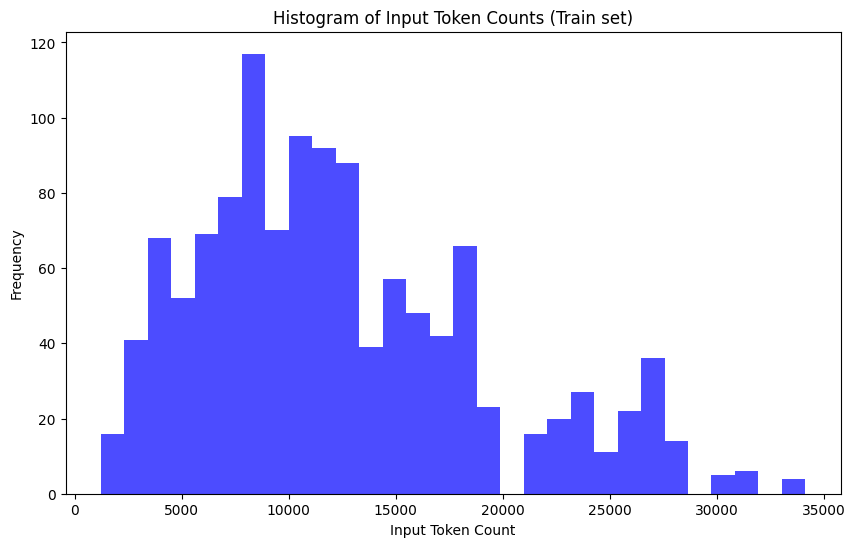

In [30]:
# Plot histogram for input token counts
plt.figure(figsize=(10, 6))
plt.hist(train_df["input_token_count"], bins=30, color='blue', alpha=0.7)
plt.xlabel("Input Token Count")
plt.ylabel("Frequency")
plt.title("Histogram of Input Token Counts (Train set)")
plt.show()

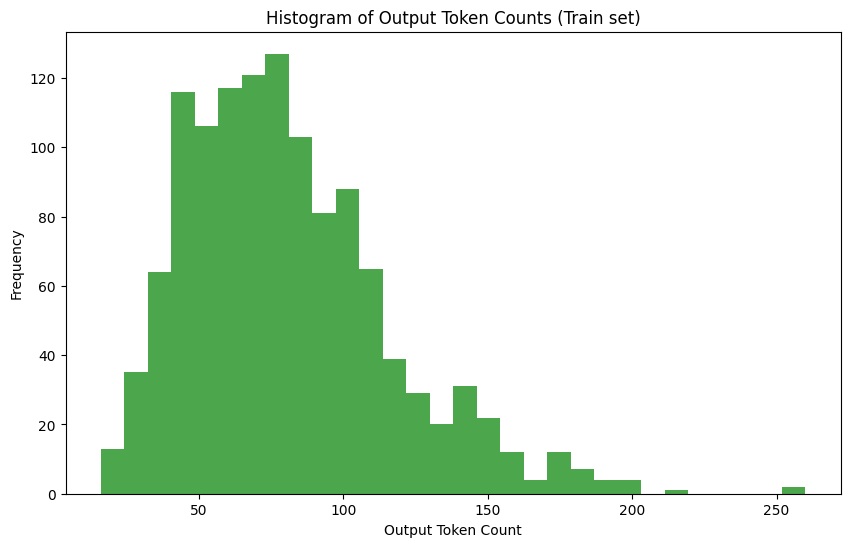

In [31]:
# Adjust the following column names accordingly.
# input_column = "clean_input" if "clean_input" in train_df.columns else "input"
# output_column = "clean_output" if "clean_output" in train_df.columns else "output"

# # Count tokens for each row using the T5 tokenizer
# train_df["input_token_count"] = train_df[input_column].apply(lambda x: len(tokenizer.tokenize(x)))
# train_df["output_token_count"] = train_df[output_column].apply(lambda x: len(tokenizer.tokenize(x)))

# Plot histogram for output token counts
plt.figure(figsize=(10, 6))
plt.hist(train_df["output_token_count"], bins=30, color='green', alpha=0.7)
plt.xlabel("Output Token Count")
plt.ylabel("Frequency")
plt.title("Histogram of Output Token Counts (Train set)")
plt.show()

In [32]:
# Compute mean and standard deviation for input token counts
input_mean = train_df["input_token_count"].mean()
input_std = train_df["input_token_count"].std()
# Compute mean and standard deviation for output token counts
output_mean = train_df["output_token_count"].mean()
output_std = train_df["output_token_count"].std()

print("Input Token Count - Mean: {:.2f}, Standard Deviation: {:.2f}".format(input_mean, input_std))
print("Output Token Count - Mean: {:.2f}, Standard Deviation: {:.2f}".format(output_mean, output_std))

Input Token Count - Mean: 12429.60, Standard Deviation: 6764.65
Output Token Count - Mean: 80.76, Standard Deviation: 35.46


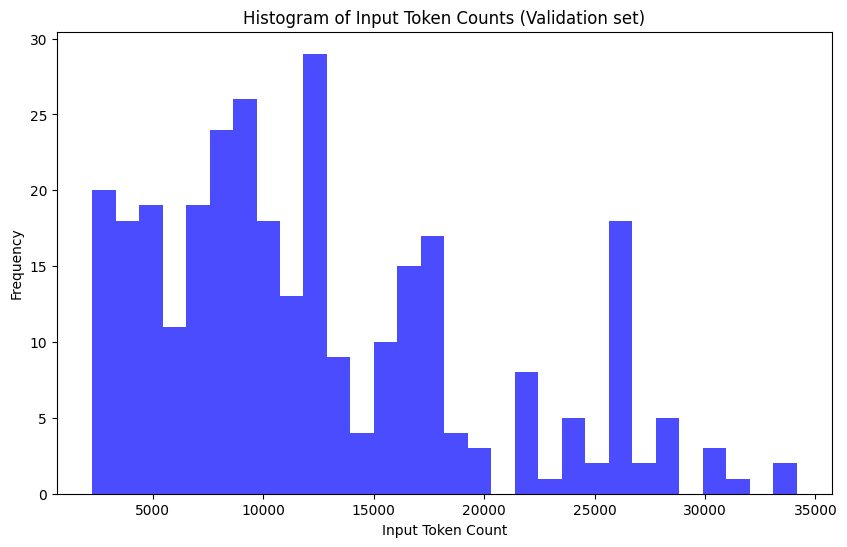

In [33]:
# Plot histogram for input token counts
plt.figure(figsize=(10, 6))
plt.hist(val_df["input_token_count"], bins=30, color='blue', alpha=0.7)
plt.xlabel("Input Token Count")
plt.ylabel("Frequency")
plt.title("Histogram of Input Token Counts (Validation set)")
plt.show()

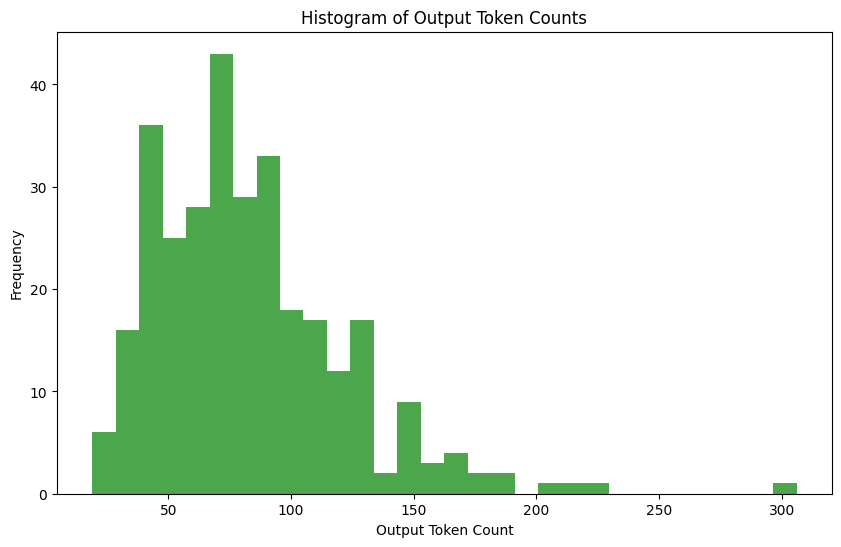

In [25]:
# Plot histogram for output token counts
plt.figure(figsize=(10, 6))
plt.hist(val_df["output_token_count"], bins=30, color='green', alpha=0.7)
plt.xlabel("Output Token Count")
plt.ylabel("Frequency")
plt.title("Histogram of Output Token Counts (Validation set)")
plt.show()

In [34]:
# Compute mean and standard deviation for input token counts
input_mean = val_df["input_token_count"].mean()
input_std = val_df["input_token_count"].std()
# Compute mean and standard deviation for output token counts
output_mean = val_df["output_token_count"].mean()
output_std = val_df["output_token_count"].std()

print("Input Token Count - Mean: {:.2f}, Standard Deviation: {:.2f}".format(input_mean, input_std))
print("Output Token Count - Mean: {:.2f}, Standard Deviation: {:.2f}".format(output_mean, output_std))

Input Token Count - Mean: 12349.07, Standard Deviation: 7329.43
Output Token Count - Mean: 82.98, Standard Deviation: 38.78


In [35]:
!pip install wordcloud

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.7/167.7 kB 3.1 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [36]:
from wordcloud import WordCloud

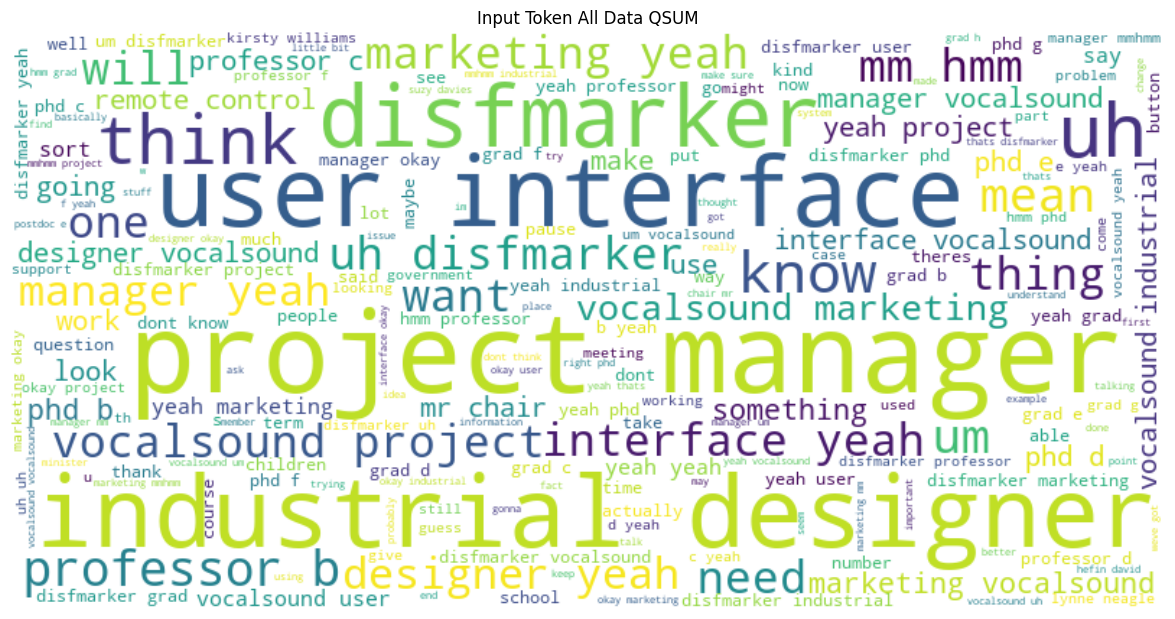

In [44]:
# Aggregate text for word cloud generation
input_text = " ".join(combined_df[input_column].tolist())
output_text = " ".join(combined_df[output_column].tolist())

# Create word cloud objects
wordcloud_input = WordCloud(width=800, height=400, background_color='white').generate(input_text)
wordcloud_output = WordCloud(width=800, height=400, background_color='white').generate(output_text)

# Plot the word cloud for input texts
plt.figure(figsize=(15, 7.5))
plt.imshow(wordcloud_input, interpolation='bilinear')
plt.axis("off")
plt.title("Input Token All Data QSUM")
plt.show()

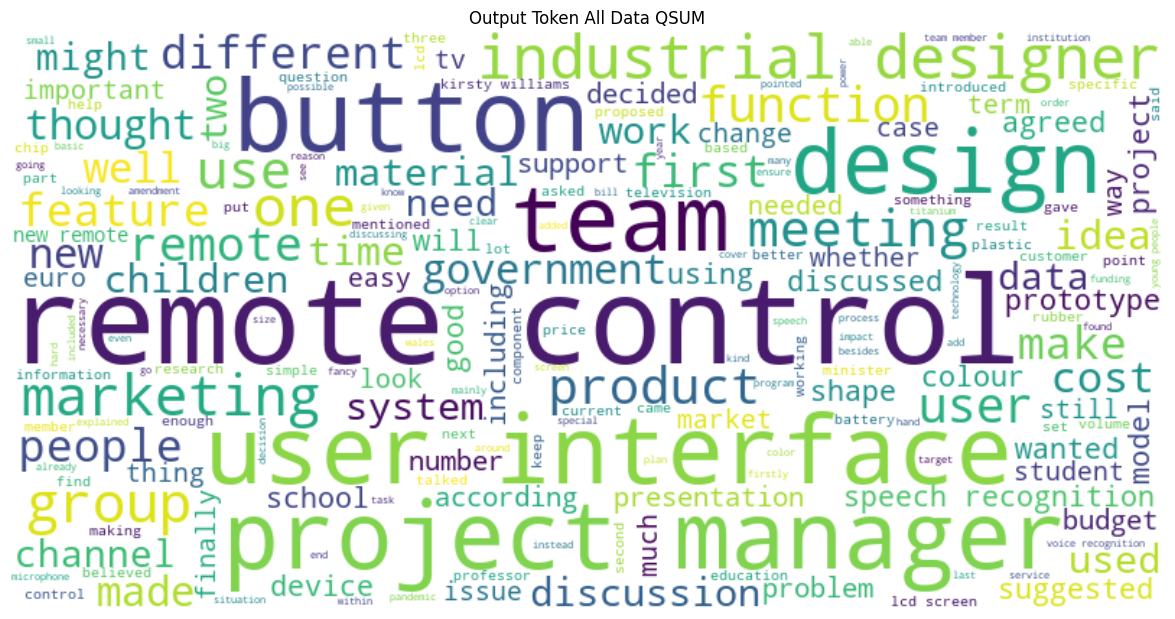

In [45]:
# Plot the word cloud for input texts
plt.figure(figsize=(15, 7.5))
plt.imshow(wordcloud_output, interpolation='bilinear')
plt.axis("off")
plt.title("Output Token All Data QSUM")
plt.show()

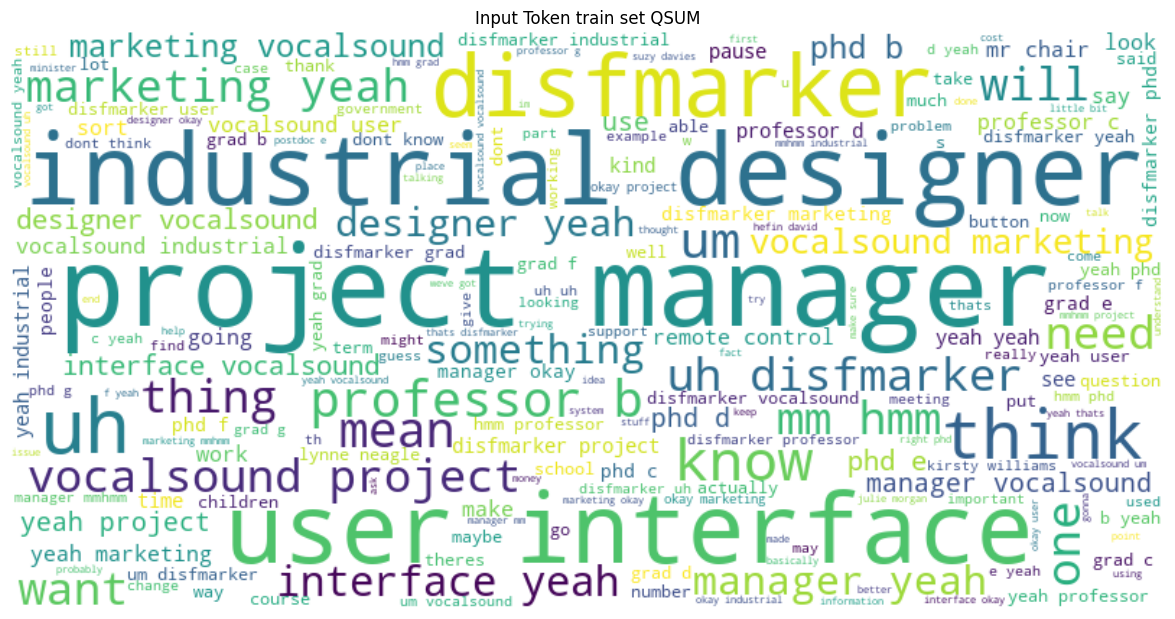

In [46]:
# Aggregate text for word cloud generation
input_text = " ".join(train_df[input_column].tolist())
output_text = " ".join(train_df[output_column].tolist())

# Create word cloud objects
wordcloud_input = WordCloud(width=800, height=400, background_color='white').generate(input_text)
wordcloud_output = WordCloud(width=800, height=400, background_color='white').generate(output_text)

# Plot the word cloud for input texts
plt.figure(figsize=(15, 7.5))
plt.imshow(wordcloud_input, interpolation='bilinear')
plt.axis("off")
plt.title("Input Token train set QSUM")
plt.show()

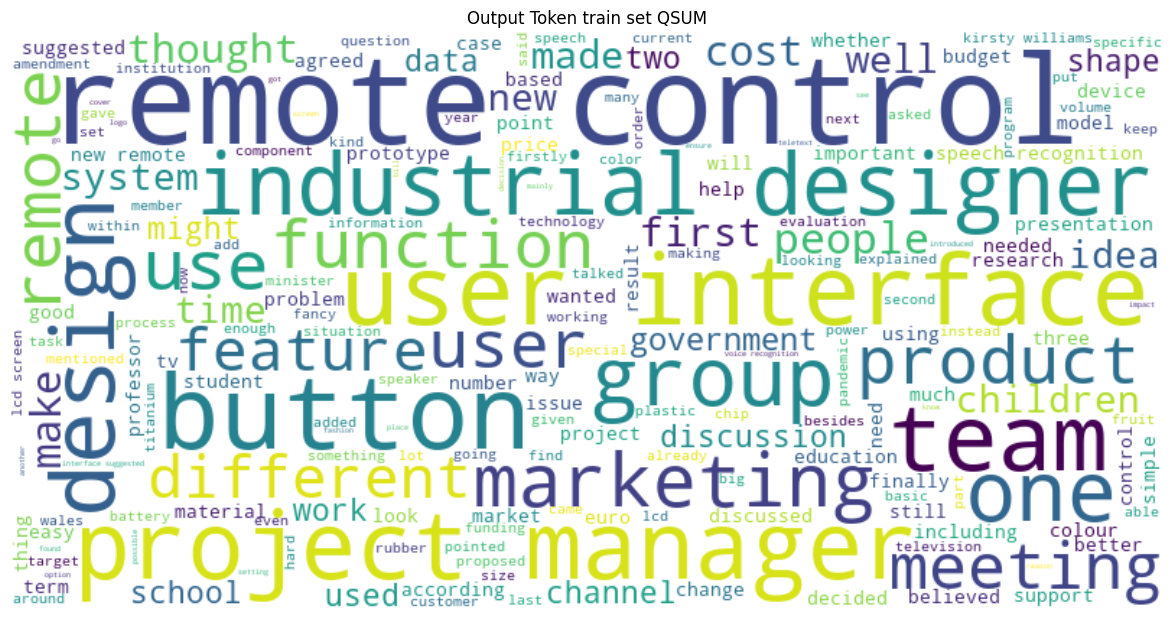

In [47]:
# Plot the word cloud for input texts
plt.figure(figsize=(15, 7.5))
plt.imshow(wordcloud_output, interpolation='bilinear')
plt.axis("off")
plt.title("Output Token train set QSUM")
plt.show()

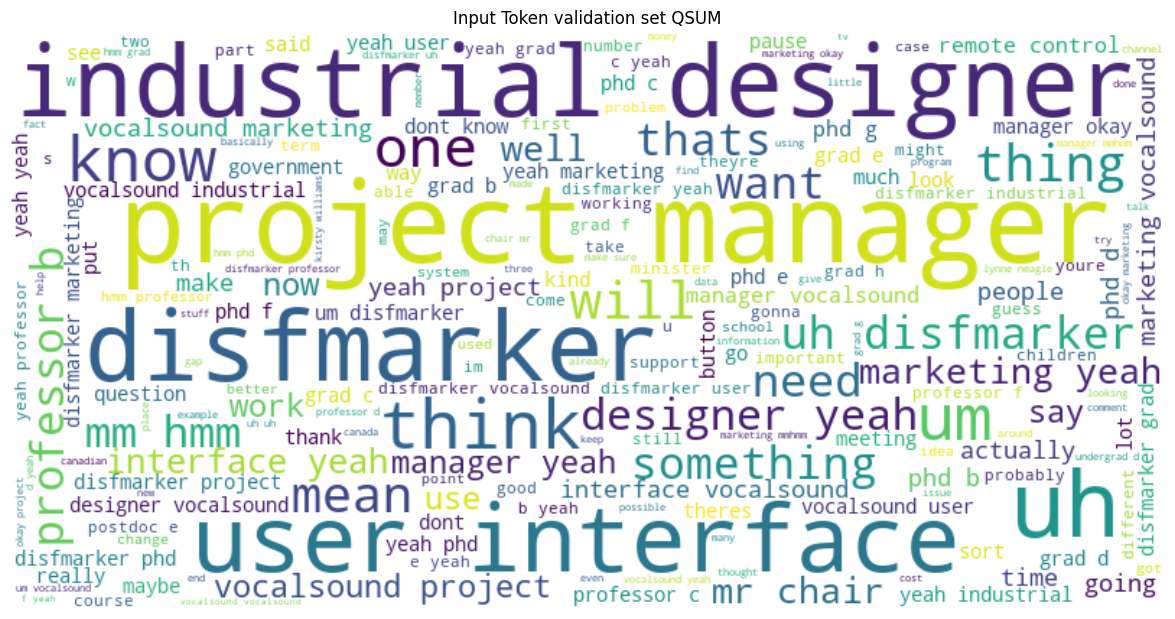

In [48]:
# Aggregate text for word cloud generation
input_text = " ".join(val_df[input_column].tolist())
output_text = " ".join(val_df[output_column].tolist())

# Create word cloud objects
wordcloud_input = WordCloud(width=800, height=400, background_color='white').generate(input_text)
wordcloud_output = WordCloud(width=800, height=400, background_color='white').generate(output_text)

# Plot the word cloud for input texts
plt.figure(figsize=(15, 7.5))
plt.imshow(wordcloud_input, interpolation='bilinear')
plt.axis("off")
plt.title("Input Token validation set QSUM")
plt.show()

In [ ]:
# Plot the word cloud for input texts
plt.figure(figsize=(15, 7.5))
plt.imshow(wordcloud_output, interpolation='bilinear')
plt.axis("off")
plt.title("Output Token Validation set QSUM")
plt.show()